
# Projet Lichess


## Présentation du projet : LiChess Data Analysis


**LiChess** est une des principales plateformes d’échecs en ligne, avec plus de **3 millions de parties jouées par jour**. Ce projet analyse un dataset issu des parties jouées en **septembre 2020**, notre but est donc de répondre aux trois questions suivantes :

1. **Taux d'erreurs (blunders, mistakes, inaccuracies)** :  
   Analyse par coup, catégorie ELO et parties Blitz (les plus populaires).

2. **Probabilité de victoire en fonction des ouvertures** :  
   Pour les Blancs et les Noirs, par type de partie (Blitz, Fast, Classic) et catégorie ELO.

3. **Prédiction du résultat d'une partie** :  
   Étude des variables comme le nombre d’erreurs ou la différence d’ELO pour prédire l’issue d’une partie.

Pour ce faire, nous allons utiliser **Apache Spark** sur notre notebook créé sur Google Colab :


## Importation des biblliothèques

Nous commençons par importer les bibliothèques nécessaires pour ce projet. D'autres seront ajoutées si besoin.

In [2]:
from pyspark.sql.functions import col, when, count, sum as _sum
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession

from pyspark.sql.functions import udf
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import seaborn as sns



## Téléchargement du dataset

Nous utilisons le dataset des parties jouées sur LiChess en septembre 2020, disponible sur Kaggle. Nous avons mis ce dataset dans google drive, afin de le télécharger pour pouvoir l'utiliser sur ce projet, car collab ne permet pas de stocker les données de façon permanente.



In [ ]:
import gdown

file_id = "1EOXzqSebJ8wEd5wQ5wCIZZzyWr-ob395"

download_url = f'https://drive.google.com/uc?id={file_id}'

output_path = "/content/Sept_20_analysis.csv"
gdown.download(download_url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1EOXzqSebJ8wEd5wQ5wCIZZzyWr-ob395
From (redirected): https://drive.google.com/uc?id=1EOXzqSebJ8wEd5wQ5wCIZZzyWr-ob395&confirm=t&uuid=951e2f4d-a5c2-493d-ba2f-4822756a4af4
To: /content/Sept_20_analysis.csv
100%|██████████| 860M/860M [00:11<00:00, 76.0MB/s]


'/content/Sept_20_analysis.csv'

## Initialisation de SparkSession et chargement des données

Après avoir téléchargé le dataset, nous initialisons une session Spark et chargeons le fichier CSV dans une DataFrame Spark. Ensuite, nous affichons le schéma du dataset ainsi que les 20 premières lignes et sa taille pour mieux comprendre sa structure.

In [3]:

spark = SparkSession.builder.appName("Projet LiChess").getOrCreate()


data_path = "/content/Sept_20_analysis.csv"
df = spark.read.csv(data_path, inferSchema=True, header=True)

df.printSchema()

df.show(20)
print("Taille du dataset : ", df.count())

root
 |-- GAME: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- BlackRatingDiff: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- Site: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- UTCTime: timestamp (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- WhiteRatingDiff: integer (nullable = true)
 |-- Black_elo_category: string (nullable = true)
 |-- White_elo_category: string (nullable = true)
 |-- starting_time: integer (nullable = true)
 |-- increment: integer (nullable = true)
 |-- Game_type: string (nullable = true)
 |-- Total_moves: integer (nullable = true)
 |-- Black_blunders: integer (nullable = true)
 |-- White_blunders: integer (nullable = true)
 |-- Black_mistakes: integer (nullable = true)
 |-- White_mistak

## Q1 : Taux de blunders, erreurs et imprécisions pour le type de jeu Blitz

Après avoir téléchargé le dataset et vu son schéma, on est prêts à répondre la première question.

Pour répondre à cette question, on va d'abord filtrer les parties de type Blitz. Ensuite, on créera une fonction pour catégoriser les joueurs en fonction de leur ELO et on ajoutera des colonnes pour les catégories ELO des blancs et des noirs. On ne se concentrera que sur les parties où les deux joueurs sont dans la même catégorie pour calculer les taux de blunders, erreurs et imprécisions. Le taux est calculé en ajoutant les erreurs des deux joueurs et en divisant par le nombre total de mouvements, en fonction de chaque catégorie.

In [22]:


df_blitz = df.filter(col("Game_type") == "Blitz")


print("Il y a {} parties blitz".format(df_blitz.count()))

def categorize_elo(elo):
    if 1200 <= elo < 1500:
        return "occasional player "
    elif 1500 <= elo < 1800:
        return "good club player"
    elif 1800 <= elo < 2000:
        return "very good club player"
    elif 2000 <= elo < 2400:
        return "national and international level (IM)"
    elif 2400 <= elo <= 2800:
        return "GMI, World Champions"
    else:
        return "unrated"

# Créer une UDF pour la catégorisation
categorize_elo_udf = udf(categorize_elo, StringType())


df_blitz = df_blitz.withColumn("WhiteEloCategory", categorize_elo_udf(col("WhiteElo")))
df_blitz = df_blitz.withColumn("BlackEloCategory", categorize_elo_udf(col("BlackElo")))


df_same_category = df_blitz.filter(col("WhiteEloCategory") == col("BlackEloCategory"))

metrics = (
    df_same_category.groupBy("WhiteEloCategory")
    .agg(
        (_sum(col("Black_blunders") + col("White_blunders")) / _sum(col("Total_moves"))).alias("BlunderRate"),
        (_sum(col("Black_mistakes") + col("White_mistakes")) / _sum(col("Total_moves"))).alias("MistakeRate"),
        (_sum(col("Black_inaccuracies") + col("White_inaccuracies")) / _sum(col("Total_moves"))).alias("InaccuracyRate"),
    )
    .orderBy("WhiteEloCategory")
)


metrics.show()


Il y a 1812120 parties blitz
+--------------------+--------------------+-------------------+-------------------+
|    WhiteEloCategory|         BlunderRate|        MistakeRate|     InaccuracyRate|
+--------------------+--------------------+-------------------+-------------------+
|GMI, World Champions| 0.03153593531719616|0.06489503789954766|0.07186211093619085|
|    good club player| 0.05964650831479701|0.09849008092019497|0.09098977415627109|
|national and inte...|0.041136093407083414|0.08098591524550514|0.08317791090185256|
|  occasional player | 0.07356205649595114|0.10357127308249324| 0.0901653740438934|
|             unrated| 0.09473917059456047|0.10674789171184616|0.08984669994468976|
|very good club pl...|0.049822631523699444|0.09185612856049091|0.08929071290770434|
+--------------------+--------------------+-------------------+-------------------+



In [23]:
# Convertir les résultats du DataFrame Spark 'metrics' en pandas DataFrame
metrics_df = metrics.toPandas()

print(metrics_df)

# Préparer le DataFrame pour chaque taux et trier par ordre décroissant
df_blunder = metrics_df[["WhiteEloCategory", "BlunderRate"]].sort_values(by="BlunderRate", ascending=False)
df_mistake = metrics_df[["WhiteEloCategory", "MistakeRate"]].sort_values(by="MistakeRate", ascending=False)
df_inaccuracy = metrics_df[["WhiteEloCategory", "InaccuracyRate"]].sort_values(by="InaccuracyRate", ascending=False)

                        WhiteEloCategory  BlunderRate  MistakeRate  \
0                   GMI, World Champions     0.031536     0.064895   
1                       good club player     0.059647     0.098490   
2  national and international level (IM)     0.041136     0.080986   
3                     occasional player      0.073562     0.103571   
4                                unrated     0.094739     0.106748   
5                  very good club player     0.049823     0.091856   

   InaccuracyRate  
0        0.071862  
1        0.090990  
2        0.083178  
3        0.090165  
4        0.089847  
5        0.089291  


## Présentation des résultats

Désormais, on va afficher le taux pour chaque type d'erreurs (blunder, mistake et innacuracies) afin de comprendre comment ces taux varient en fonction du niveau des joeurs

### - BlunderRate





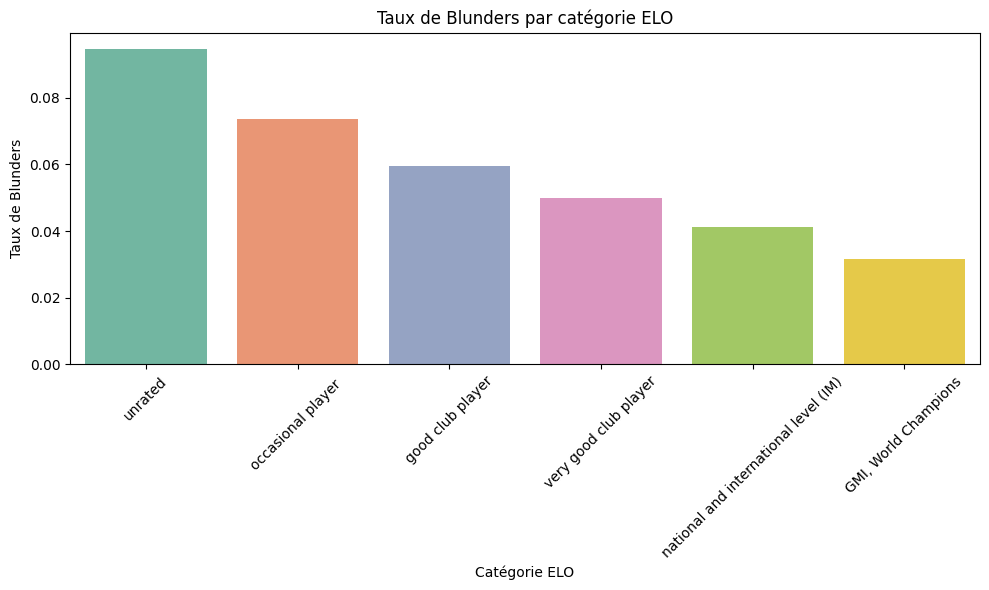

In [ ]:
# Visualisation pour BlunderRate
plt.figure(figsize=(10, 6))
sns.barplot(x="WhiteEloCategory", y="BlunderRate", data=df_blunder, palette="Set2", hue="WhiteEloCategory")
plt.title("Taux de Blunders par catégorie ELO")
plt.xlabel("Catégorie ELO")
plt.ylabel("Taux de Blunders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

D'après le graphique, on observe que le taux de blunders est plus élevé chez les joueurs non classés ("unrated") et les joueurs occasionnels ("occasional player"), qui ont un classement ELO plus bas.On peut donc en déduire que les joueurs avec un classement inférieur commettent davantage d'erreurs significatives. En revanche, les joueurs de niveau "GMI, World Champions" présentent un taux de blunders beaucoup plus faible, car ils commettent moins d'erreurs critiques. Ainsi, le taux de blunders augmente avec la diminution du classement ELO.

### - MistakeRate



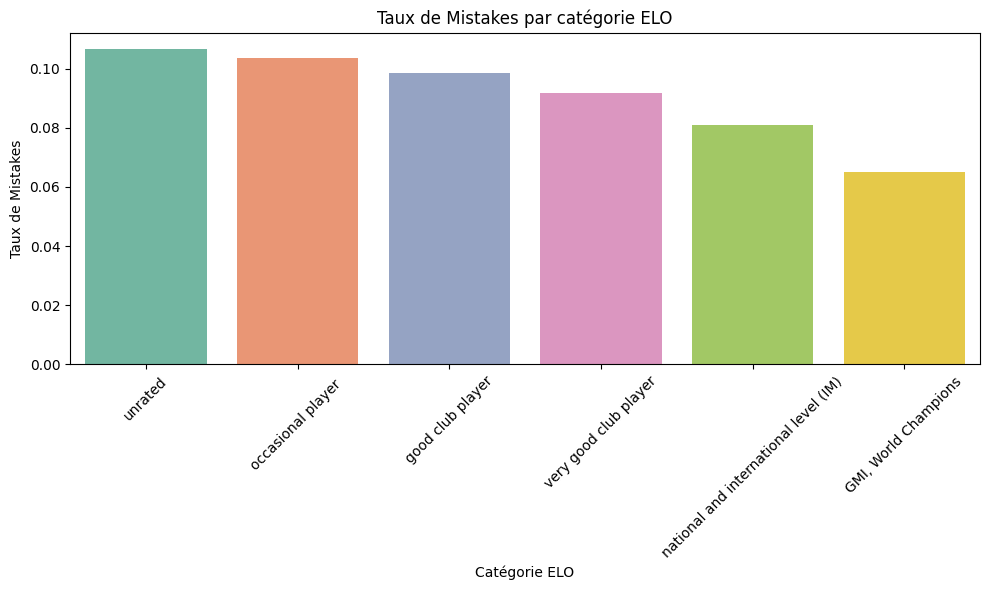

In [ ]:
# Visualisation pour MistakeRate
plt.figure(figsize=(10, 6))
sns.barplot(x="WhiteEloCategory", y="MistakeRate", data=df_mistake, palette="Set2", hue="WhiteEloCategory")
plt.title("Taux de Mistakes par catégorie ELO")
plt.xlabel("Catégorie ELO")
plt.ylabel("Taux de Mistakes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Le taux de mistakes (erreurs mineures) suit une tendance similaire à celle des blunders, bien qu'il soit plus uniforme parmi les catégories de joueurs. Les joueurs moins expérimentés, tels que les "unrated" et "occasional player", continuent de présenter des taux plus élevés, mais la différence est moins marquée que pour les blunders. Les joueurs de niveau "GMI, World Champions" restent ceux ayant le taux le plus faible.

### - InaccuracyRate

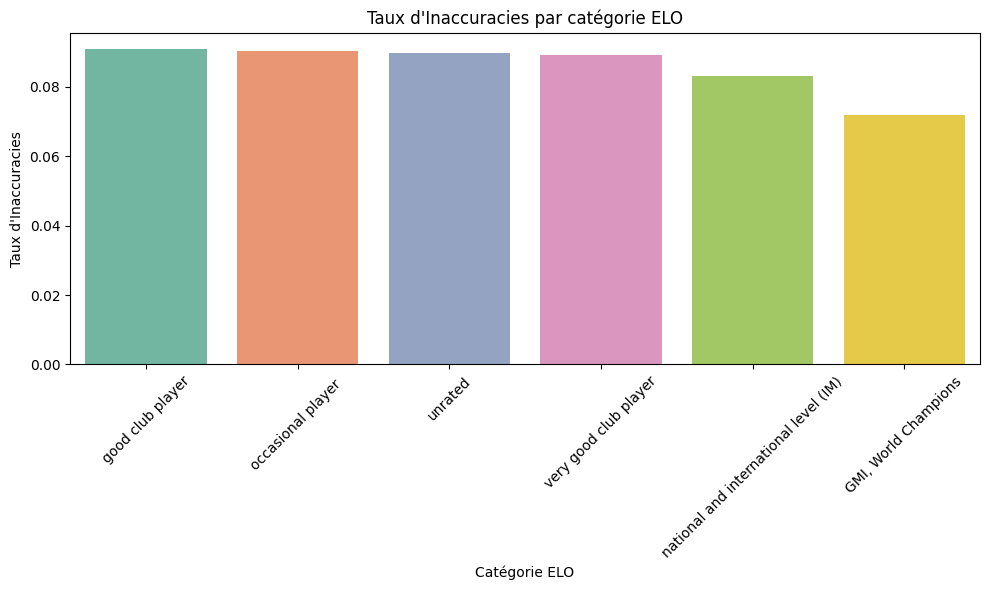

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x="WhiteEloCategory", y="InaccuracyRate", data=df_inaccuracy, palette="Set2", hue="WhiteEloCategory")
plt.title("Taux d'Inaccuracies par catégorie ELO")
plt.xlabel("Catégorie ELO")
plt.ylabel("Taux d'Inaccuracies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Le taux d'inexactitudes est plus stable entre les catégories ELO, bien qu'il existe une petite tendance à la hausse chez les joueurs de niveau inférieur. Par exemple, les "good club player" présentent un taux d'inexactitudes plus élevé que les "occasional player", bien qu'ils aient un classement plus élevé. En revanche, cette métrique montre que les inexactitudes sont relativement constantes à tous les niveaux.

## Q2 : Probabilité de victoire  en fonction de l'ouverture

Maintenant, on peut passer à la question 2. Dans cette question, nous devons calculer la probabilité de victoire en fonction de l'ouverture et du type de jeu et du niveau de Jeu. D'abord, pour les pièces blanches et ensuite pour les pièces noires.

Pour le type de jeu, on va analyser les trois types de jeu suivants : Blitz, Rapid et Classic.

### Q2.a : Quelle ouverture donne à Blanc la meilleure chance de gagner, selon la catégorie de niveau et le type de jeu (Blitz, Rapid, Classic) ?

Avant tout, on va afficher les ouvertures qui offrent la meilleure probabilité de victoire pour tous les types de jeu et tous les niveaux de joueurs, du côté des blancs.

On va donc filtrer uniquement les données où les blancs ont gagné la partie. Ensuite, on va une colonne pour compter le nombre de jeux par ouverture, catégorie Elo pour les blancs, et type de jeu, uniquement pour les parties gagnées par les blancs. On va créer aussi une colonne pour compter tous les jeux par ouverture, catégorie Elo et type de jeu. Ensuite, on va faire une jointure entre ces deux colonnes afin de calculer la probabilité de victoire.

Comme certaines parties avec certaines ouvertures contiennent peu de jeux, parfois seulement 3 ou 4, et que les blancs ont gagné la totalité de ces jeux, et la probabilité de victoire dans ce cas est de 100%, on va donc exclure les données où le nombre total de parties est inférieur à X matchs, afin de ne conserver que des données cohérentes et suffisamment significatives pour notre analyse.

In [ ]:

df = df.withColumn("White_elo_category", categorize_elo_udf(df.WhiteElo))
df = df.withColumn("Black_elo_category", categorize_elo_udf(df.BlackElo))

nb_games  = 1000

# Filtrer les données pour n'avoir que les jeux où les blancs sont vainqueurs
df_white_wins = df.filter(df.Result == "1-0")

df_white_wins_grouped = df_white_wins.groupBy("Opening", "White_elo_category", "Game_type").agg(
    F.count("GAME").alias("White_Wins")
)

df_all_games_grouped = df.groupBy("Opening", "White_elo_category", "Game_type").agg(
    F.count("GAME").alias("Total_Games")
)

# Joindre les données de victoires avec les données de jeux totaux pour calculer la probabilité de victoire
df_white_probabilities = df_white_wins_grouped.join(
    df_all_games_grouped, on=["Opening", "White_elo_category", "Game_type"], how="inner"
).withColumn(
    "Win_Probability_White", F.col("White_Wins") / F.col("Total_Games")
)

df_white_probabilities_filtered = df_white_probabilities.filter(F.col("Total_Games") >= nb_games)

df_white_probabilities_filtered.orderBy(F.col("Win_Probability_White"), ascending=False).show(50)

+--------------------+--------------------+---------+----------+-----------+---------------------+
|             Opening|  White_elo_category|Game_type|White_Wins|Total_Games|Win_Probability_White|
+--------------------+--------------------+---------+----------+-----------+---------------------+
|King's Pawn Game:...|    good club player|    Rapid|       910|       1271|   0.7159716758457907|
|King's Pawn Game:...|    good club player|    Rapid|       889|       1279|   0.6950742767787333|
|King's Pawn Game:...|  occasional player |    Rapid|       890|       1307|   0.6809487375669472|
|King's Pawn Game:...|  occasional player |    Blitz|      1150|       1705|   0.6744868035190615|
|King's Pawn Game:...|    good club player|    Blitz|       810|       1202|   0.6738768718801996|
|King's Pawn Game:...|             unrated|    Blitz|       787|       1179|   0.6675148430873622|
|King's Pawn Game:...|  occasional player |    Rapid|       951|       1433|   0.6636427076064201|
|King's Pa

On constate que les joueurs classés comme "good club player", avec l'ouverture **King's Pawn Game**, ont la meilleure probabilité de victoire pour les blancs.

Maintenant, on va analyser l'ouverture qui offre la meilleure probabilité de victoire pour les blancs, en fonction du type de jeu et de la catégorie Elo.

**Pour notre analyse, nous utiliserons les lignes de données comportant plus de 1000 matchs**

### Affichage des types de jeu disponibles

On affiche les types de jeu disponible sur le dataset, mais on ne va explorer que 3 (Classical, Rapid et Blitz)

In [ ]:
df.select("Game_type").distinct().show()


+--------------+
|     Game_type|
+--------------+
|        Bullet|
|         Blitz|
|     Classical|
|         Rapid|
|Correspondence|
+--------------+



## Quelle ouverture donne aux Blancs la meilleure chance de gagner, selon la catégorie de niveau et le type de jeu Blitz ?

On va commencer par déterminer quelle ouverture offre aux blancs la meilleure probabilité de victoire, en fonction de chaque niveau Elo et du type de jeu Blitz.

Pour ce faire, on va créer une fonction qui sera aussi utilisée pour les autres types de jeu. Cette fonction filtrera les données en fonction du type de jeu (passé en paramètre) et de la catégorie Elo (en parcourant les différents niveaux). Au cours de ce parcours, on va prendre les 5 ouvertures avec les meilleures probabilités de victoire, et enfin on tracera un graphique pour ces ouvertures en fonction des niveaux des joueurs.

In [ ]:
elo_categories_list = df_same_category.select("WhiteEloCategory").distinct().rdd.flatMap(lambda x: x).collect()

print(elo_categories_list)


['GMI, World Champions', 'occasional player ', 'very good club player', 'good club player', 'unrated', 'national and international level (IM)']


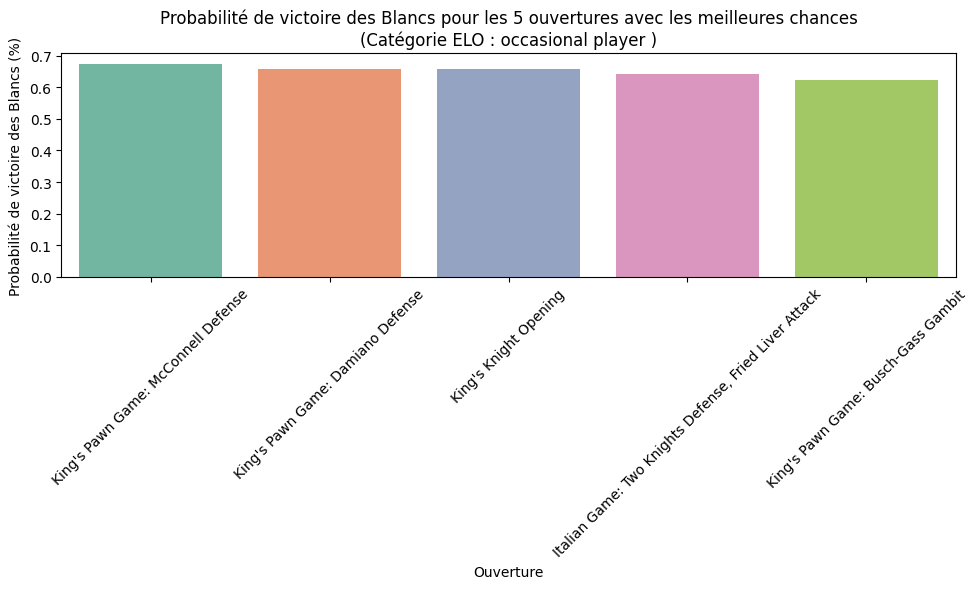

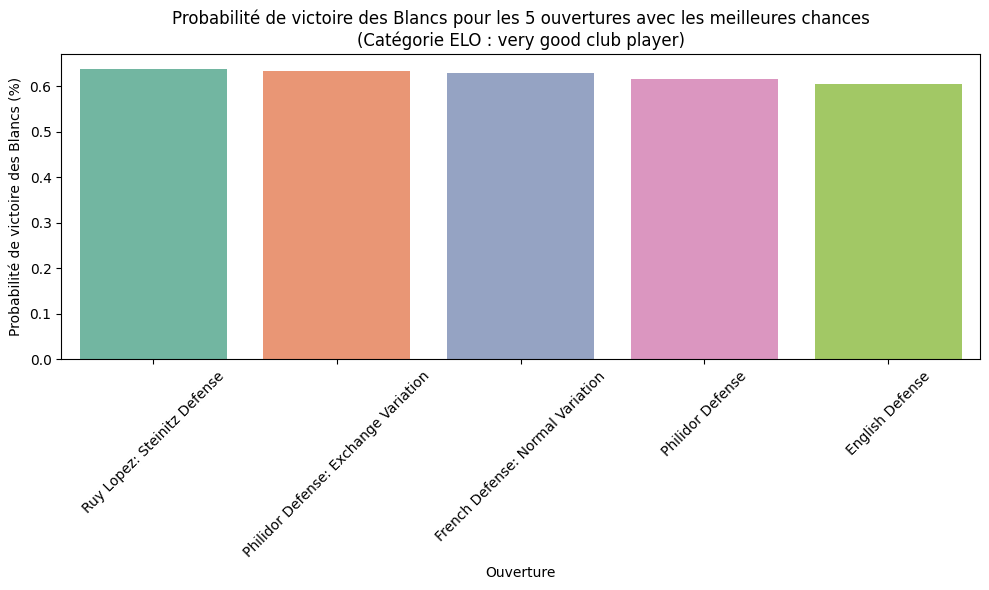

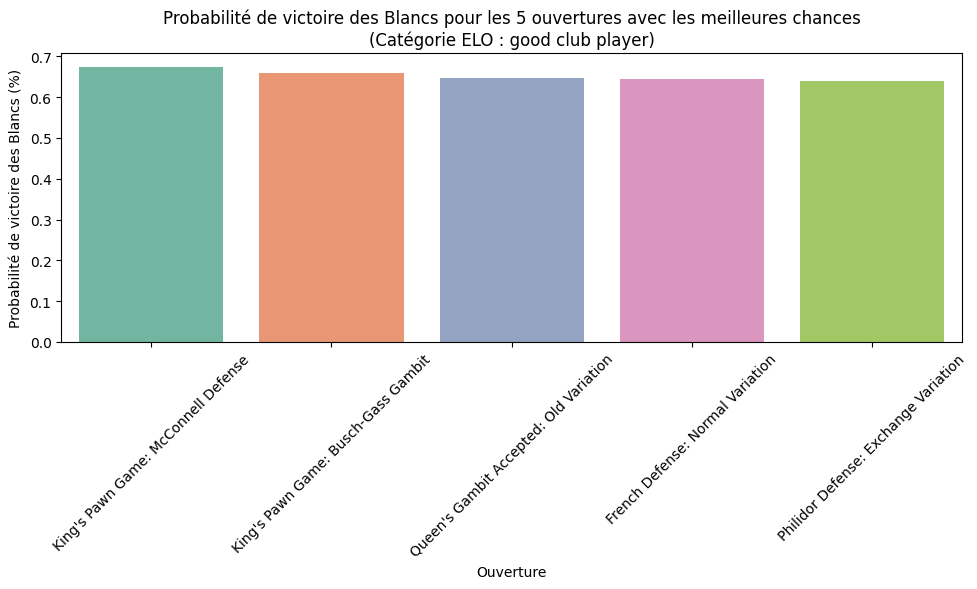

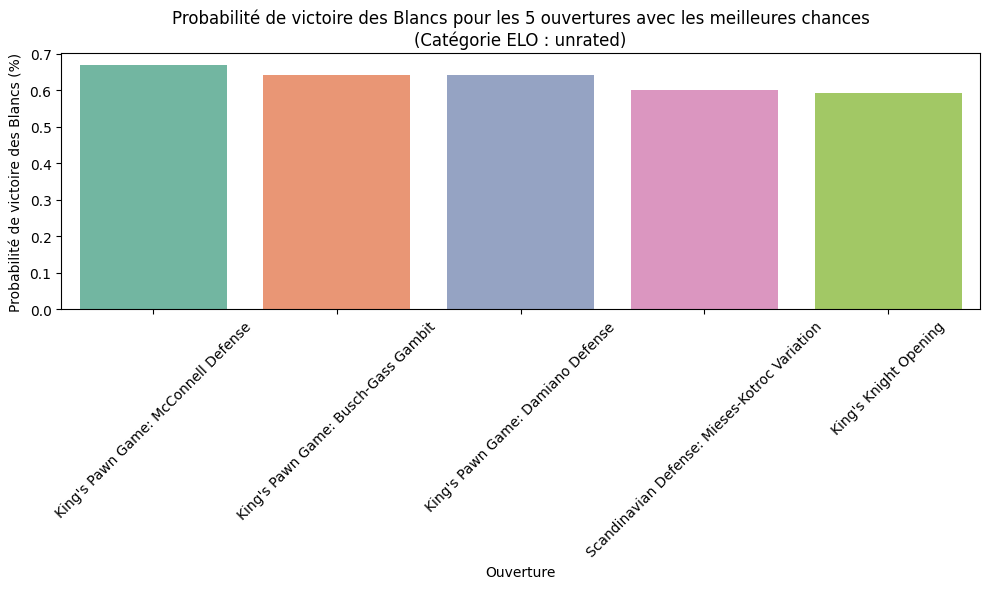

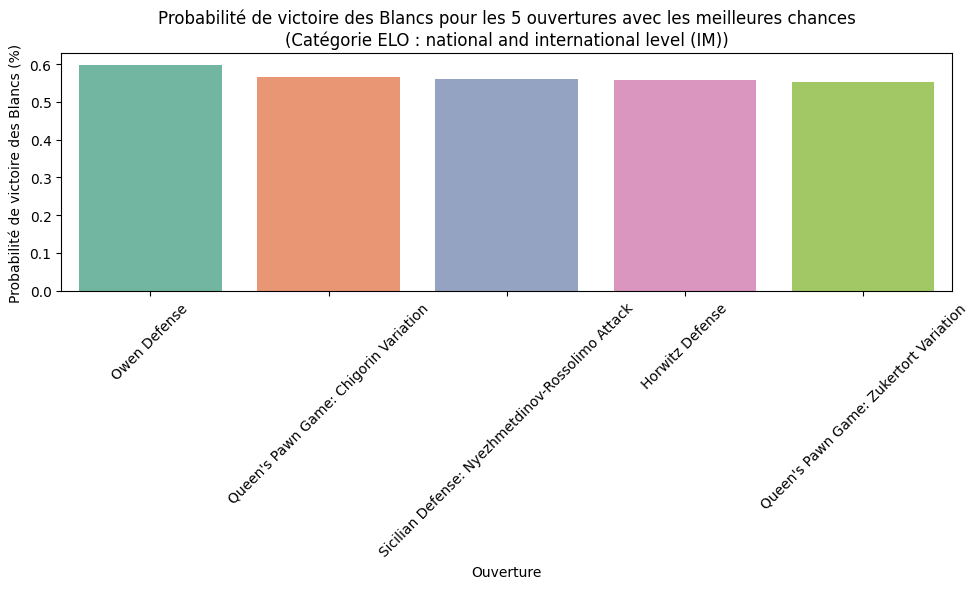

In [ ]:
def get_probability_by_game_type(game_type):

    for elo_category in elo_categories_list:

        df_game_type = df_white_probabilities_filtered.filter(
            (df_white_probabilities_filtered.Game_type == game_type) &
            (df_white_probabilities_filtered.White_elo_category == elo_category)
        ).toPandas()


        if not df_game_type.empty:
            df_game_type = df_game_type.nlargest(5, "Win_Probability_White")


        if not df_game_type.empty:
            plt.figure(figsize=(10, 6))
            sns.barplot(
                x="Opening",
                y="Win_Probability_White",
                data=df_game_type,
                hue="Opening",
                legend=False
            )
            plt.title(f"Probabilité de victoire des Blancs pour les 5 ouvertures avec les meilleures chances\n"
                      f"(Catégorie ELO : {elo_category})")
            plt.xlabel("Ouverture")
            plt.ylabel("Probabilité de victoire des Blancs (%)")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


get_probability_by_game_type("Blitz")



## Présentation des résultats

Pour une partie Blitz pour les blancs, en fonction des catégories Elo, les ouvertures qui présentent les meilleures probabilités sont les suivantes :

- **Occasional Player** : King's Pawn Game : McConnell Defense, King's Pawn Game : Damiano Defense et King's Knight Opening
- **Very Good Player** : Ruy López : Steinitz Defense, Philidor Defense : Exchange Variation et French Defense : Normal Variation
- **Good Club Player** : King's Pawn Game : McConnell Defense, King's Pawn Game : Busch-Gass Gambit et Queen's Gambit Accepted : Old Variation
- **Unrated** : King's Pawn Game : McConnell Defense, King's Pawn Game : Busch-Gass Gambit et King's Pawn Game : Damiano Defense
- **National and International Level (IM)** : Owen Defense, Queen's Pawn Game : Chigorin Variation et Sicilian Defense : Nyezhmedtinov-Rossolimo Attack

On remarque que l'ouverture **King's Pawn Game : McConnell Defense** est celle qui présente la meilleure probabilité de victoire dans au moins trois catégories Elo : *Good Club Player*, *Unrated* et *Occasional Player*.

## Quelle ouverture donne à Blanc la meilleure chance de gagner, selon la catégorie de niveau et le type de jeu Rapid (Fast) ?

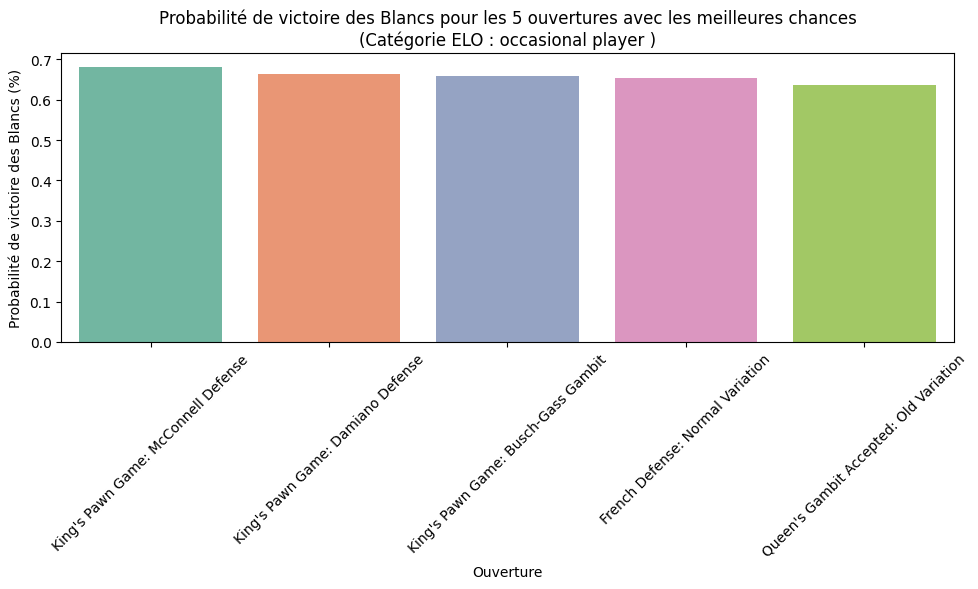

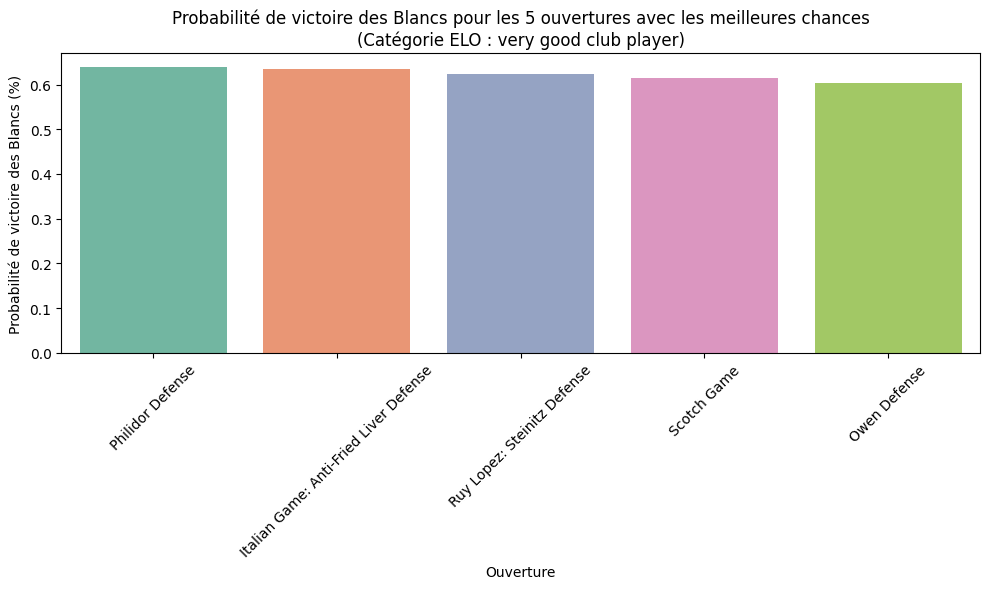

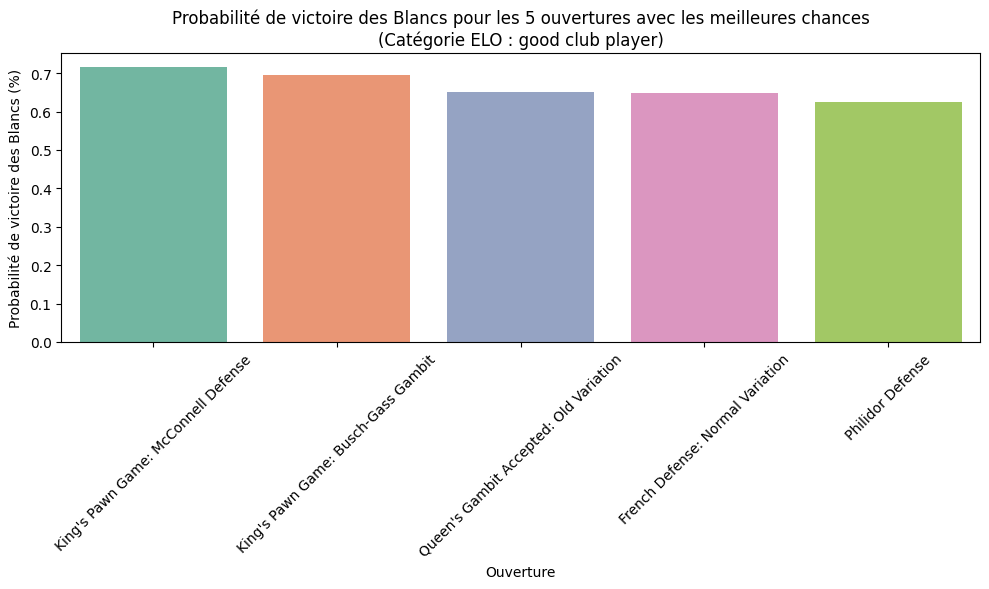

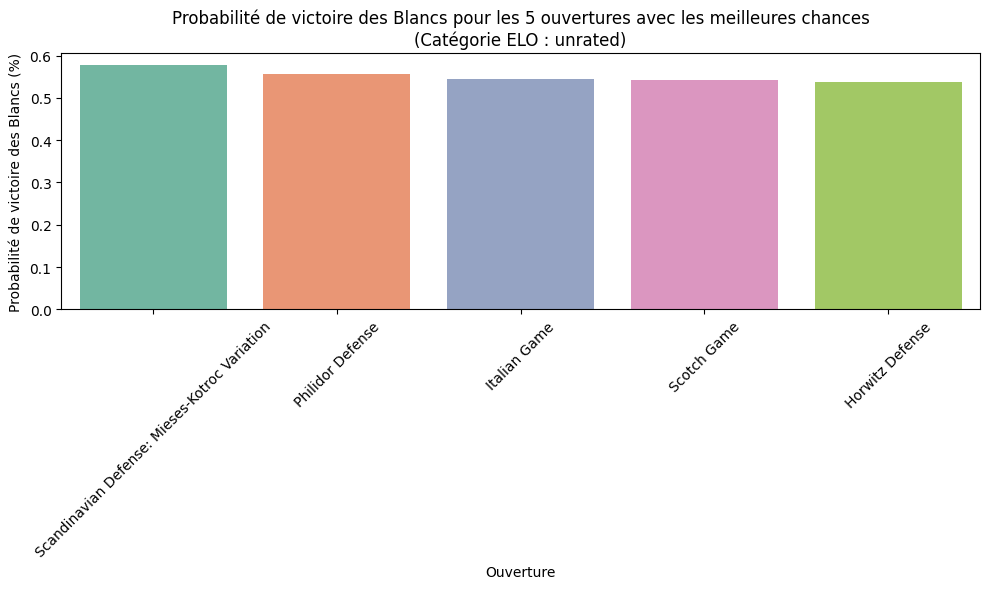

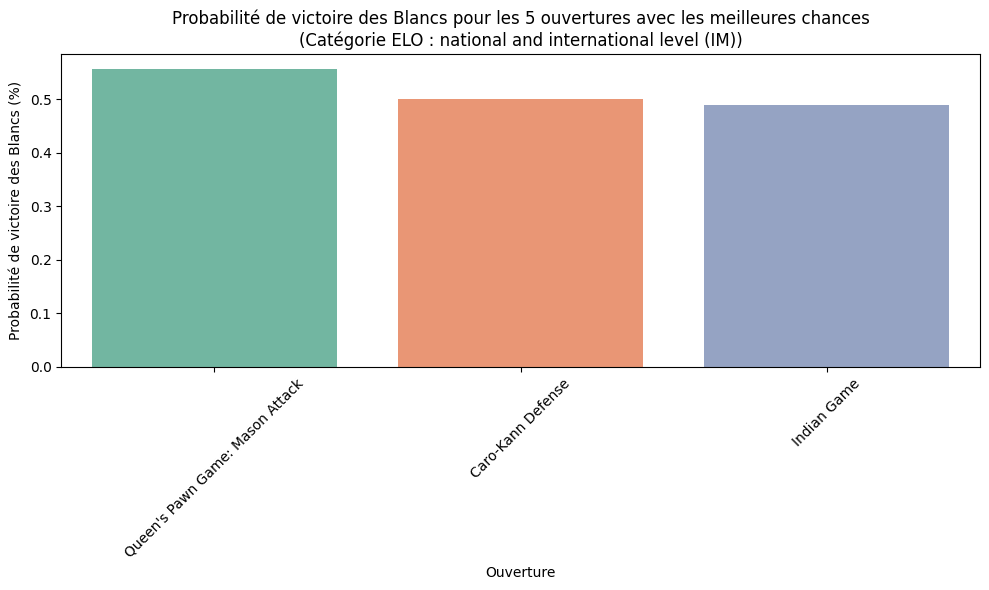

In [ ]:
get_probability_by_game_type("Rapid")

## Présentation des résultats


Pour une partie rapide (*Rapid*)  pour les blancs, les ouvertures avec les meilleures probabilités, selon les catégories ELO, sont :  

- **Occasional Player** :  King's Pawn Game : McConnell Defense, King's Pawn Game : Damiano Defense et King's Knight Opening  

- **Very Good Player** :  Philidor Defense, Italian Game : Anti-Fried Liver Defense et Ruy López : Steinitz Defense  

- **Good Club Player** :  King's Pawn Game : McConnell Defense, King's Pawn Game : Busch-Gass Gambit et Queen's Gambit Accepted : Old Variation  

- **Unrated** :  Scandinavian Defense : Mieses-Kotroc Variation, Philidor Defense  et Italian Game  

- **National and International Level (IM)** :  Queen's Pawn Game : Mason Attack , Caro-Kann Defense et Indian Game  


## Quelle ouverture donne à Blanc la meilleure chance de gagner, selon la catégorie de niveau et le type de jeu Classical (Classic) ?

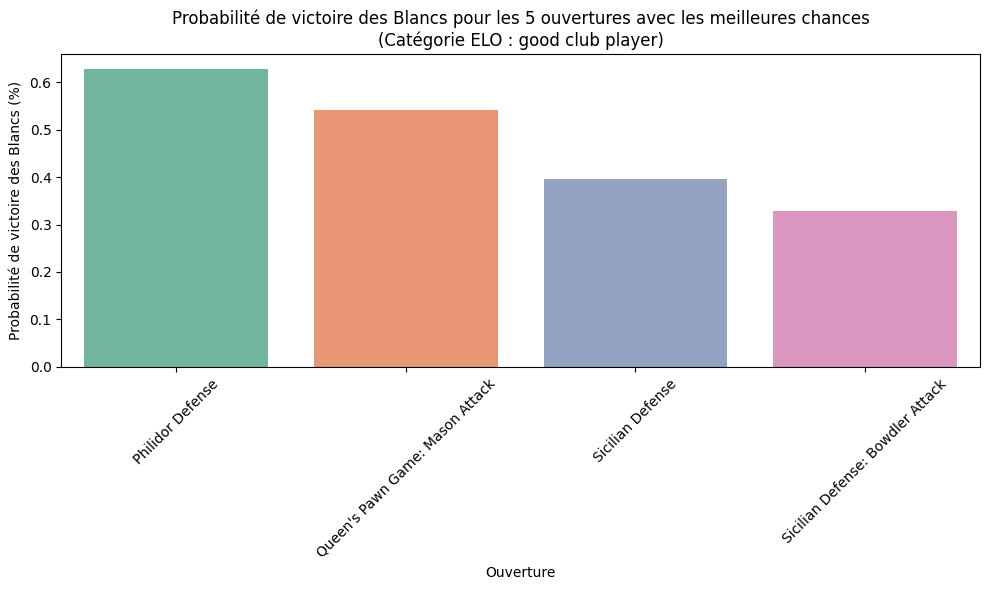

In [ ]:
get_probability_by_game_type("Classical")

## Présentation des résultats

Pour les parties *Classical*, nous avons pu identifier les 5 meilleures ouvertures uniquement pour la catégorie **Good Club Player**, car ce mode de jeu comporte moins de parties au total comparé aux modes *Blitz* et *Rapid*. De plus, l'analyse a été limitée à un minimum de 1000 parties.

Dans ce mode, seule la catégorie **Good Club Player** atteint ce seuil. Les ouvertures avec les meilleures probabilités de victoire pour cette catégorie sont : **Philidor Defense**, **Queen's Pawn Game : Mason Attack** et **Sicilian Defense**.

## Q2.b : Même question avec les noirs .

Maintenant, on va appliquer la même méthode pour les pièces noires. On va filtrer les données afin de ne conserver que celles où les noirs ont gagné. Ensuite, on va faire la méthode que l'on a faite pour les pièces blanches.

In [ ]:

df_black_wins = df.filter(df.Result == "0-1")


df_black_wins_grouped = df_black_wins.groupBy("Opening", "Black_elo_category", "Game_type").agg(
    F.count("GAME").alias("Black_Wins")
)


df_all_games_grouped = df.groupBy("Opening", "Black_elo_category", "Game_type").agg(
    F.count("GAME").alias("Total_Games")
)


df_black_probabilities = df_black_wins_grouped.join(
    df_all_games_grouped, on=["Opening", "Black_elo_category", "Game_type"], how="inner"
).withColumn(
    "Win_Probability_Black", F.col("Black_Wins") / F.col("Total_Games")
)

df_black_probabilities_filtered = df_black_probabilities.filter(F.col("Total_Games") >= nb_games)

df_black_probabilities_filtered.orderBy(F.col("Win_Probability_Black"), ascending=False).show(50)

+--------------------+--------------------+---------+----------+-----------+---------------------+
|             Opening|  Black_elo_category|Game_type|Black_Wins|Total_Games|Win_Probability_Black|
+--------------------+--------------------+---------+----------+-----------+---------------------+
|Sicilian Defense:...|very good club pl...|    Rapid|      1602|       2401|   0.6672219908371512|
|Caro-Kann Defense...|    good club player|    Rapid|       692|       1053|   0.6571699905033238|
|Sicilian Defense:...|national and inte...|    Blitz|       655|       1011|   0.6478733926805144|
|Sicilian Defense:...|    good club player|Classical|       749|       1161|   0.6451335055986219|
|Van't Kruijs Opening|    good club player|    Rapid|      2094|       3266|   0.6411512553582364|
|King's Pawn Game:...|    good club player|    Rapid|       768|       1198|   0.6410684474123539|
|King's Pawn Game:...|             unrated|    Blitz|       762|       1193|   0.6387259010896899|
|Sicilian 

De façon générale, on constate que les joueurs classés comme "very good club player" sur le mode de jeu Blitz et avec une ouverture **Sicilian Defense** ont la meilleure probabilité de victoire pour les noirs.

Maintenant, on va analyser l'ouverture qui donne la meilleure probabilité de victoire pour les noirs selon le type de jeu et la catégorie elo.

**Pour notre analyse, nous avons limité les parties à 1000 minimum**

## Quelle ouverture donne aux noirs la meilleure chance de gagner, selon la catégorie de niveau et le type de jeu Blitz ?

On va créer une fonction similaire à celle que l'on avait créée pour calculer la probabilité pour les pièces blances.

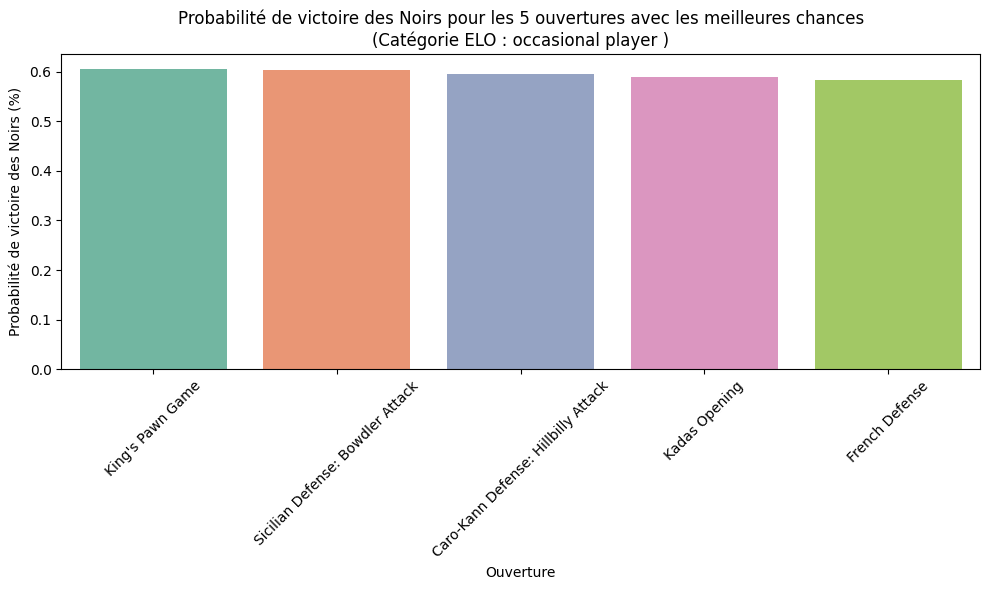

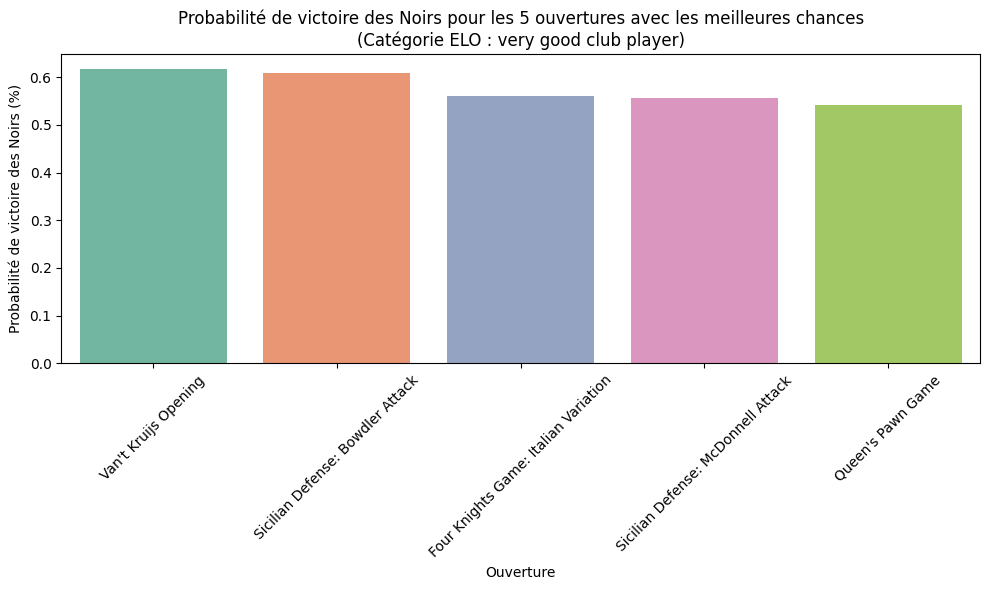

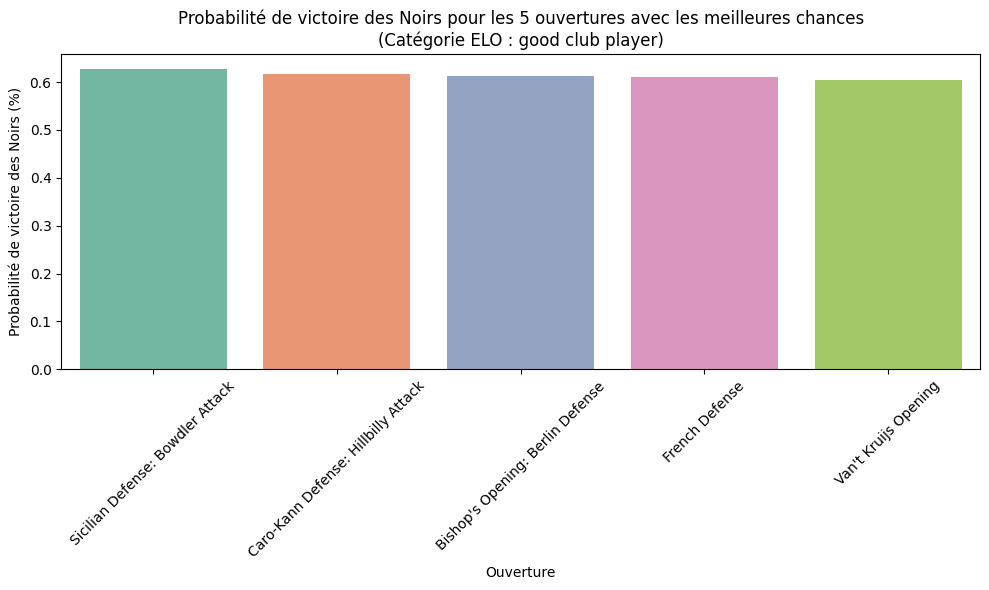

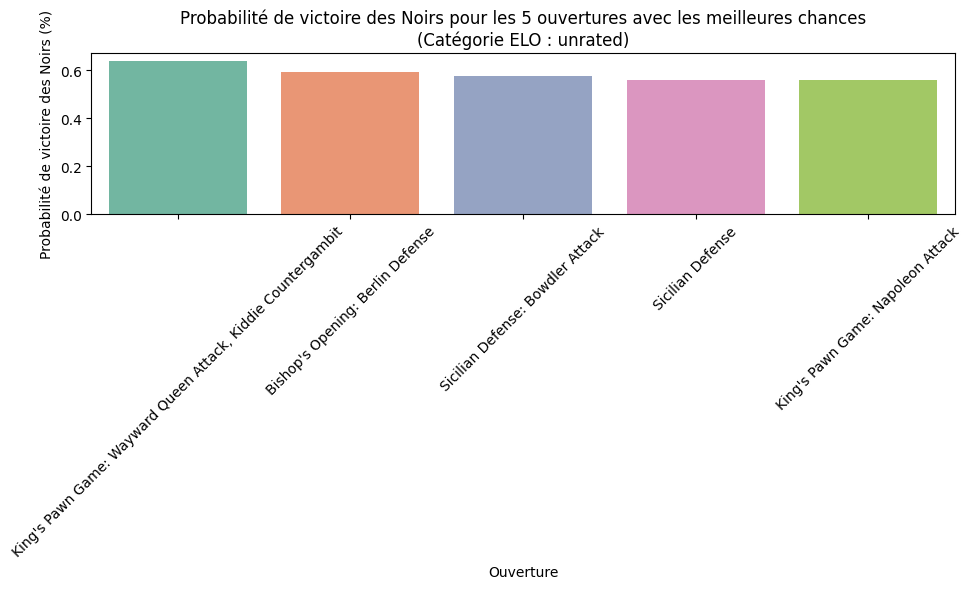

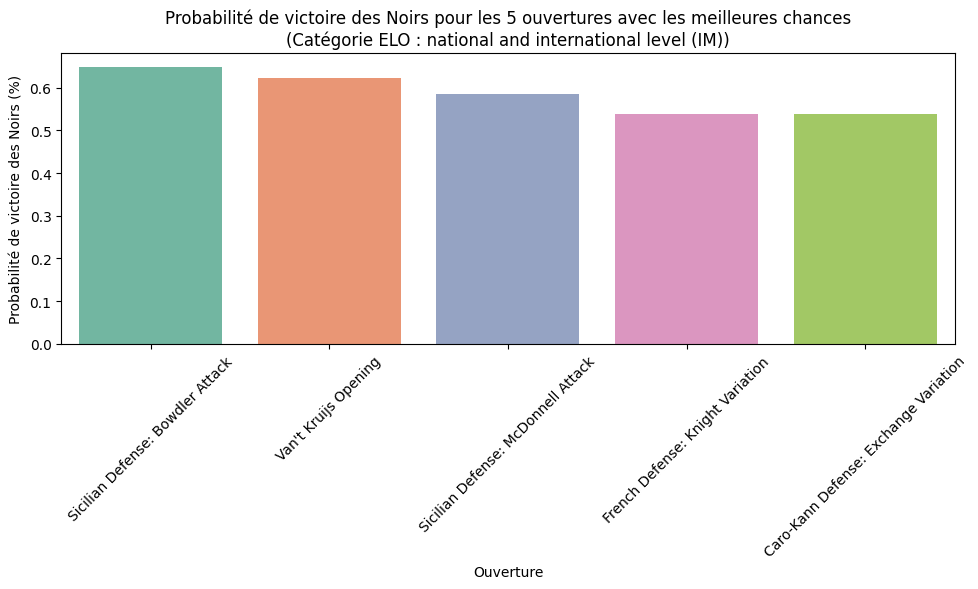

In [ ]:
def get_probability_by_game_type_blacks(game_type):

    for elo_category in elo_categories_list:

        df_game_type = df_black_probabilities_filtered.filter(
            (df_black_probabilities_filtered.Game_type == game_type) &
            (df_black_probabilities_filtered.Black_elo_category == elo_category)
        ).toPandas()


        if not df_game_type.empty:
            df_game_type = df_game_type.nlargest(5, "Win_Probability_Black")


        if not df_game_type.empty:
            plt.figure(figsize=(10, 6))
            sns.barplot(
                x="Opening",
                y="Win_Probability_Black",
                data=df_game_type,
                hue="Opening",
                legend=False
            )
            plt.title(f"Probabilité de victoire des Noirs pour les 5 ouvertures avec les meilleures chances\n"
                      f"(Catégorie ELO : {elo_category})")
            plt.xlabel("Ouverture")
            plt.ylabel("Probabilité de victoire des Noirs (%)")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


get_probability_by_game_type_blacks("Blitz")


## Présentation des résultats


Pour une partie *Blitz* avec les Noirs, en fonction des catégories ELO, les ouvertures qui présentent les meilleures probabilités sont les suivantes :  

- **Occasional Player** :  King's Pawn Game, Sicilian Defense : Bowdler Attack et Caro-Kann Defense : Hillbilly Attack  

- **Very Good Player** :  Van't Kruijs Opening, Sicilian Defense : Bowdler Attack et Four Knights Game : Italian Variation  

- **Good Club Player** :  Sicilian Defense : Bowdler Attack, Caro-Kann Defense : Hillbilly Attack et Bishop's Opening : Berlin Defense  

- **Unrated** :  King's Pawn Game : Wayward Queen Attack, Kiddie Countergambit, Bishop's Opening : Berlin Defense et Sicilian Defense : Bowdler Attack  

- **National and International Level (IM)** :  Sicilian Defense : Bowdler Attack, Van't Kruijs Opening et Sicilian Defense : McDonnell Attack  



## Quelle ouverture donne aux noirs la meilleure chance de gagner, selon la catégorie de niveau et le type de jeu Fast (Rapid) ?

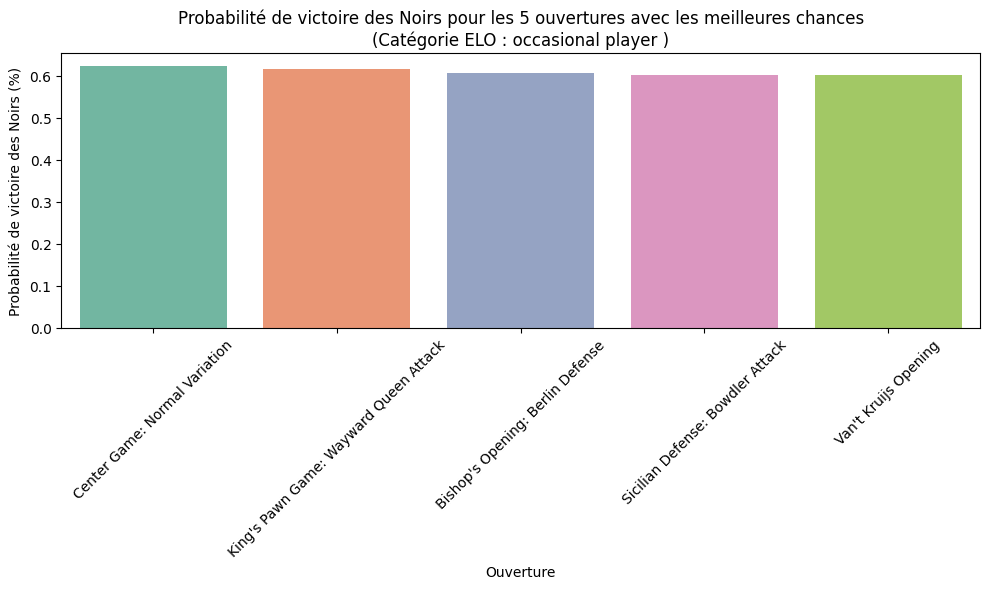

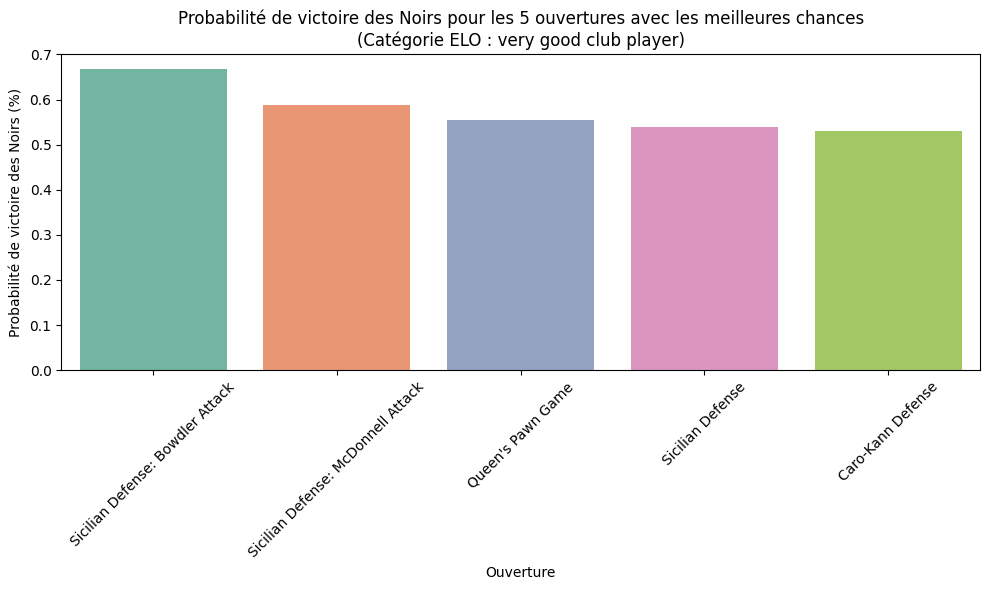

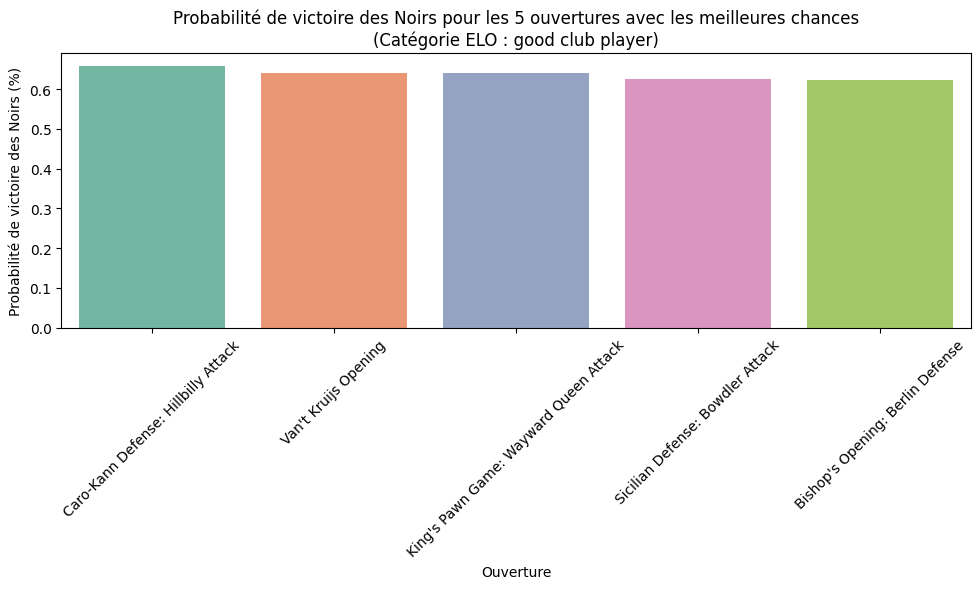

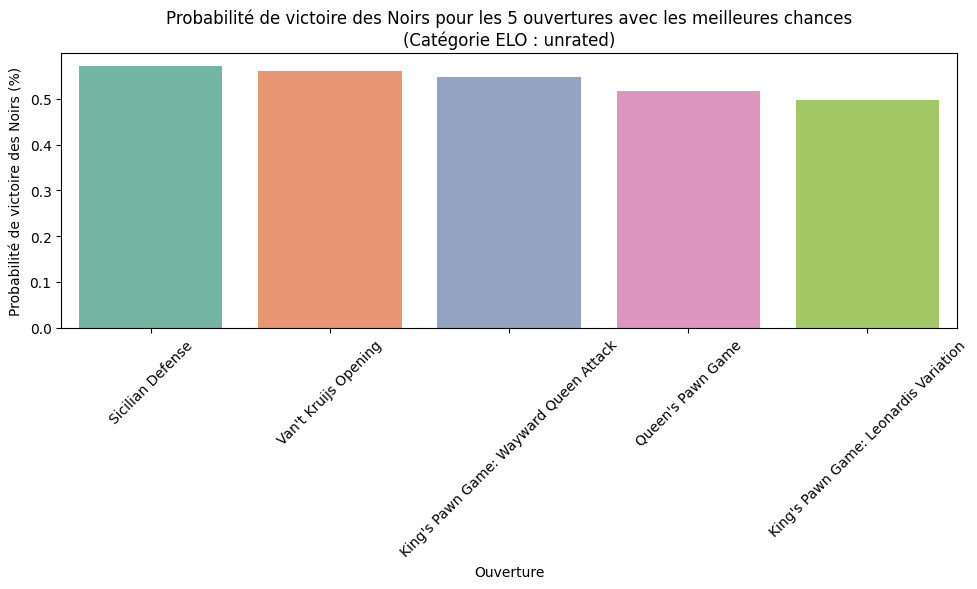

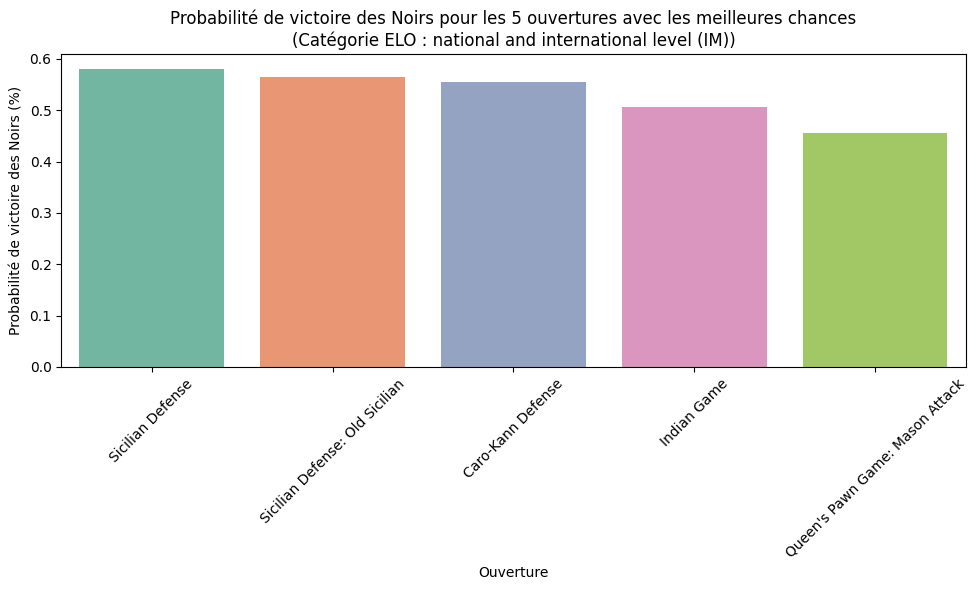

In [ ]:
get_probability_by_game_type_blacks("Rapid")

## Présentation des résultats


Pour une partie rapide (*Rapid*) avec les Noirs, les ouvertures qui présentent les meilleures probabilités, selon les catégories ELO, sont :  

- **Occasional Player** :  Center Game : Normal Variation, King's Pawn Game : Wayward Queen Attack et Bishop's Opening : Berlin Defense  

- **Very Good Player** :  Sicilian Defense : Bowdler Attack, Sicilian Defense : McDonnell Attack et Queen's Pawn Game  

- **Good Club Player** :  Caro-Kann Defense : Hillbilly Attack, Van't Kruijs Opening et King's Pawn Game : Wayward Queen Attack  

- **Unrated** :  Sicilian Defense, Van't Kruijs Opening et King's Pawn Game : Wayward Queen Attack  

- **National and International Level (IM)** : Sicilian Defense, Sicilian Defense : Old Sicilian et Caro-Kann Defense  



## Quelle ouverture donne aux noirs la meilleure chance de gagner, selon la catégorie de niveau et le type de jeu Classic (Classical) ?

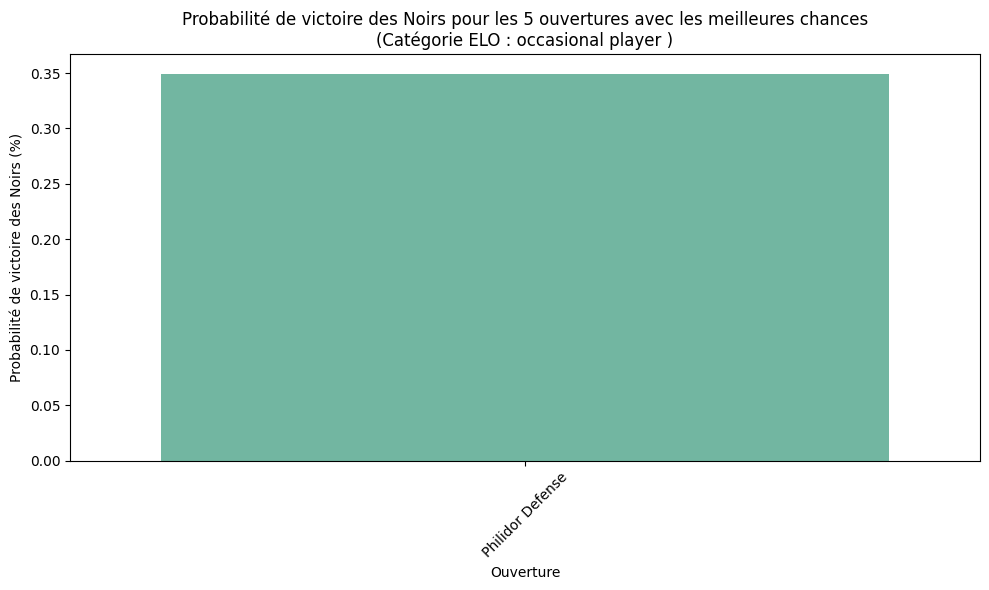

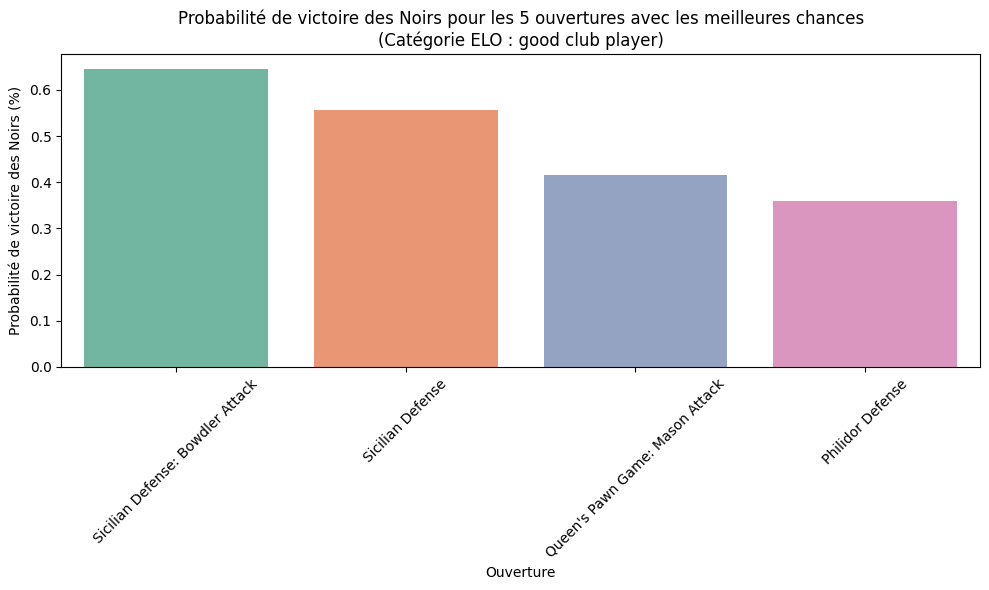

In [ ]:
get_probability_by_game_type_blacks("Classical")

## Présentation des résultats

Pour les parties *Classical*, nous avons pu identifier les 5 meilleures ouvertures uniquement pour la catégorie **Good Club Player**, en raison du nombre limité de parties disponibles dans ce mode.  

Les ouvertures qui présentent les meilleures probabilités de victoire pour cette catégorie sont :  **Sicilian Defense : Bowdler Attack**, **Sicilian Defense** et **Queen's Pawn Game : Mason Attack**  

Dans la catégorie ELO **Occasional Player**, l'ouverture qui offre la meilleure probabilité de victoire est : **Philidor Defense**  




## Q3 - Prédiction des résultats

L'objectif est de déterminer si une ligne de données dans notre dataset peut prédire l'issue du jeu (victoire ou défaite) et avec quelle probabilité. Pour ce faire, nous devons utiliser différentes variables comme les erreurs (blunders, mistakes, inaccuracies), la différence d'ELO, etc. Nous devons donc vérifier si ces variables permettent de prédire le résultat du jeu.

Pour réaliser cette analyse, nous allons commencer par utiliser des méthodes statistiques pour vérifier les relations entre les différentes variables et le résultat de la partie. Autrement dit, nous allons analyser la corrélation entre les différentes variables et le résultat de la partie.

Pour répondre à cette question, nous allons suivre plusieurs étapes :

1. **Préparation des données** : Nous allons sélectionner les variables que l'on souhaite utiliser pour analyser leur influence sur la victoire. Nous utiliserons les variables suivantes : "BlackElo", "WhiteElo", "Black_blunders", "White_blunders", "Black_mistakes", "White_mistakes", "Black_inaccuracies", "White_inaccuracies", "Result".

2. **Entraînement du modèle** : Cette étape prend beaucoup de temps, car elle nous aide à entraîner notre modèle.

3. **Prédiction** : Pour cette étape, nous allons utiliser le RandomForestClassifier. Nous avions initialement prévu d'utiliser celui de la bibliothèque `sklearn`, cependant la session Colab plantait à chaque fois en raison de la mémoire RAM. Nous avons donc décidé d'utiliser celui de Spark, qui offre moins de fonctionnalités pour l'affichage de la prédiction et sa classification.

4. **Évaluation du modèle** : Dans cette étape, nous allons évaluer le modèle entraîné et afficher sa précision ainsi que d'autres métriques, telles que le F1 score.

5. **Influence des variables sur le résultat** : Nous analyserons ici l'influence des variables sur le résultat du jeu.

### Etape 1 : Préparation des données


In [5]:


df_prediction = df.select("BlackElo", "WhiteElo", "Black_blunders", "White_blunders",
                     "Black_mistakes", "White_mistakes", "Black_inaccuracies",
                     "White_inaccuracies", "Result"
)

df_prediction.show()


+--------+--------+--------------+--------------+--------------+--------------+------------------+------------------+------+
|BlackElo|WhiteElo|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Result|
+--------+--------+--------------+--------------+--------------+--------------+------------------+------------------+------+
|    1143|    1180|             4|             2|             0|             3|                 3|                 1|   0-1|
|    1504|    1381|             2|             1|             1|             1|                 7|                 5|   0-1|
|    1933|    1485|             0|             1|             1|             2|                 8|                 8|   0-1|
|    1710|    2040|             4|             2|             1|             5|                 3|                 4|   0-1|
|    1598|    2163|             1|             0|             1|             1|                 6|                 2|   1-0|


In [16]:

from pyspark.ml.feature import VectorAssembler, StringIndexer


variables_prediction = ["BlackElo", "WhiteElo", "Black_blunders", "White_blunders",
    "Black_mistakes", "White_mistakes", "Black_inaccuracies",
    "White_inaccuracies"]

assembler = VectorAssembler(inputCols=variables_prediction[:-1], outputCol="features")
df_transformed = assembler.transform(df_prediction)

# Convertir la colonne "Result" en labels numériques
indexer = StringIndexer(inputCol="Result", outputCol="label")
df_transformed = indexer.fit(df_transformed).transform(df_transformed)

# Diviser les données en ensembles d'entraînement et de test
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)



### Etape 2 : Entraîner le modèle

In [17]:
# Cette étape prend au moins 10 minutes
from pyspark.ml.classification import RandomForestClassifier

rf_classifier = RandomForestClassifier(numTrees=100, seed=42, labelCol="label", featuresCol="features")


rf_model = rf_classifier.fit(train_data)

### Etape 3: Faire des prédictions

In [18]:

predictions = rf_model.transform(test_data)


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.50968811213948...|
|  0.0|       1.0|[0.47610836405999...|
|  0.0|       0.0|[0.52663067053375...|
|  1.0|       1.0|[0.09566264081807...|
|  0.0|       0.0|[0.89752317443605...|
|  1.0|       0.0|[0.49798670770493...|
|  1.0|       1.0|[0.36618212315624...|
|  0.0|       0.0|[0.46494173099377...|
|  0.0|       0.0|[0.89920703372668...|
|  0.0|       0.0|[0.47782600515931...|
|  1.0|       1.0|[0.23458108077639...|
|  0.0|       1.0|[0.15693490549161...|
|  1.0|       0.0|[0.47619983930844...|
|  1.0|       1.0|[0.20051142270607...|
|  1.0|       0.0|[0.48459168129033...|
|  0.0|       0.0|[0.76381833177392...|
|  1.0|       1.0|[0.35252232717590...|
|  0.0|       0.0|[0.90090271765761...|
|  0.0|       1.0|[0.22035347566562...|
|  1.0|       0.0|[0.51150880573738...|
+-----+----------+--------------------+
only showing top 20 rows



### Etape 4: Evaluation du modèle

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Calculer la précision
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.2f}")

# Évaluer d'autres métriques comme f1 score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1 Score: {f1_score:.2f}")

Accuracy: 0.80
F1 Score: 0.79


### Etape 5 : Importance des variables

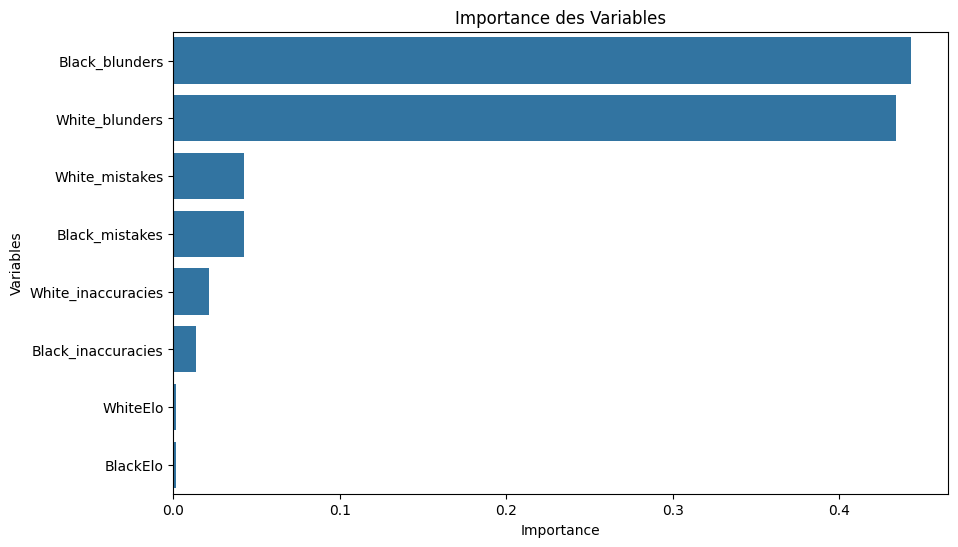

In [20]:
feature_importance = rf_model.featureImportances.toArray()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

features_df = pd.DataFrame({
    "Feature": variables_prediction,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Afficher les importances des variables
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=features_df)
plt.title("Importance des Variables")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.show()

## Présentation des résultats

On a utilisé RandomForestClassifier de PySpark, après des difficultés avec la version de Sklearn, on a obtenu une précision de 0.80 et un F1 score de 0.79, surpassant la probabilité de victoire basée sur la différence d'ELO (0.76 pour 200 points). Les blunders ont un impact majeur sur le résultat de la partie, suivis des mistakes, tandis que l'ELO a une influence moins significative comparé à ces variables.

Ainsi, une ligne de données dans le fichier peut effectivement prédire l'issue de la partie, avec une probabilité.